In [1]:
# IMPORTATION DATASET & MODULES POUR EXPLOITER 

import pandas as pd
df = pd.read_csv('events.csv')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# TRANSFORMATION DU TIMESTAMP EN PLUSIEURS FORMATS DE DATE 

from datetime import datetime
df['date'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour
df.head()

,timestamp,visitorid,event,itemid,transactionid,date,year,month,day,dayofweek,hour
0,1433221332117,257597,view,355908,NaN,2015-06-02 07:02:12.117,2015,6,2,1,7
1,1433224214164,992329,view,248676,NaN,2015-06-02 07:50:14.164,2015,6,2,1,7
2,1433221999827,111016,view,318965,NaN,2015-06-02 07:13:19.827,2015,6,2,1,7
3,1433221955914,483717,view,253185,NaN,2015-06-02 07:12:35.914,2015,6,2,1,7
4,1433221337106,951259,view,367447,NaN,2015-06-02 07:02:17.106,2015,6,2,1,7


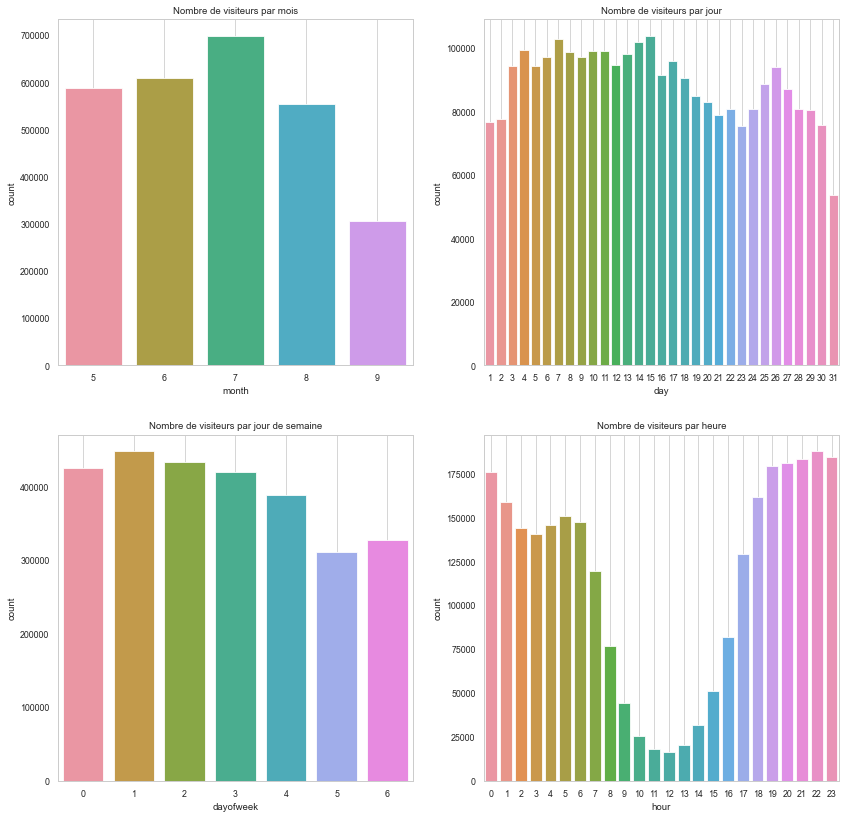

In [3]:
# PREMIERE VISUALISATION DES DONNES

# Style 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette(['#39A7D0','#36ADA4'])

# Format 
plt.figure(figsize = (14,14))

# Visiteurs par mois
plt.subplot(221)
sns.countplot(x='month', data=df)
plt.title('Nombre de visiteurs par mois')
plt.grid()

# Visiteurs par jour
plt.subplot(222)
sns.countplot(x='day', data=df)
plt.title('Nombre de visiteurs par jour')
plt.grid()

# Visiteurs par jour de semaine
plt.subplot(223)
sns.countplot(x='dayofweek', data=df)
plt.title('Nombre de visiteurs par jour de semaine')
plt.grid()

# Visiteurs par heure
plt.subplot(224)
sns.countplot(x='hour', data=df)
plt.title('Nombre de visiteurs par heure')
plt.grid()

In [3]:
####  TABLEAU TRANSACTIONS - EVENTS #####

# Créer 2 tableaux transaction et tous les events
non_transactions = df
transactions = df.loc[df.event == "transaction"]

# Merger les deux tableaux sur visitorid
inner_merged_total = pd.merge(transactions, non_transactions, on=["visitorid"], how="inner")

# Trier le tableau mergé par visitorid, date d'event, itemid
inner_merged_total = inner_merged_total.sort_values(by=['visitorid','date_y','itemid_x'])

# Calculer le time-diff entre transaction est event et le convertir en second
inner_merged_total['event_diff_second'] = inner_merged_total['date_x'] - inner_merged_total['date_y']
inner_merged_total['event_diff_second'] = inner_merged_total['event_diff_second'] / np.timedelta64(1, 's')

# Limiter en 24h
transaction_24h = inner_merged_total.loc[inner_merged_total['event_diff_second'] < 86400]
transaction_made_24h = transaction_24h.loc[inner_merged_total['itemid_x'] == inner_merged_total['itemid_y']]

# Supprimer certaines colonnes
transaction_made_24h = transaction_made_24h.drop(['timestamp_x','timestamp_y','transactionid_y'], axis=1)

# Supprimer des events après transactions 
transaction_made_24h = transaction_made_24h.loc[transaction_made_24h.event_diff_second >= 0]
transaction_made_24h

,visitorid,event_x,itemid_x,transactionid_x,date_x,year_x,month_x,day_x,dayofweek_x,hour_x,event_y,itemid_y,date_y,year_y,month_y,day_y,dayofweek_y,hour_y,event_diff_second
10906025,172,transaction,10034,9725.0,2015-08-15 03:29:01.686,2015,8,15,5,3,view,10034,2015-08-15 02:49:12.998,2015,8,15,5,2,2388.688
10906024,172,transaction,10034,9725.0,2015-08-15 03:29:01.686,2015,8,15,5,3,addtocart,10034,2015-08-15 02:50:16.912,2015,8,15,5,2,2324.774
10905985,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,2015,8,15,5,3,view,465522,2015-08-15 03:06:38.438,2015,8,15,5,3,1342.792
10905996,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,2015,8,15,5,3,addtocart,465522,2015-08-15 03:13:39.691,2015,8,15,5,3,921.539
10905993,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,2015,8,15,5,3,addtocart,465522,2015-08-15 03:13:48.324,2015,8,15,5,3,912.906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10554877,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,2015,8,5,2,1,view,360922,2015-08-05 01:03:14.670,2015,8,5,2,1,490.954
10554878,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,2015,8,5,2,1,addtocart,360922,2015-08-05 01:05:35.724,2015,8,5,2,1,349.900
10554883,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,2015,8,5,2,1,transaction,360922,2015-08-05 01:11:25.624,2015,8,5,2,1,0.000
11786291,1407398,transaction,218917,10009.0,2015-07-07 05:47:15.969,2015,7,7,1,5,addtocart,218917,2015-07-07 05:34:38.082,2015,7,7,1,5,757.887


In [4]:
### TABLEAU TIME SUM TRANSACTIONS ###

# Créer un tableau avec transactionid, visitorid et date d'evenement
calcul_time = pd.DataFrame(transaction_made_24h,columns=['transactionid_x','visitorid','date_y'])

# Calculer time diff entre le 1er evenement et la transaction (== le dernier evenement)
g = calcul_time.groupby('transactionid_x', group_keys=False)
time_sum_tran = pd.DataFrame(g['date_y'].apply(lambda x: (x.iat[-1] - x.iat[0])/ np.timedelta64(1, 's'))) # Explication ? 
time_sum_tran = time_sum_tran.rename(columns={"date_y": "sum_time_second"})

# Convertir second en minute et en heure
time_sum_tran['sum_time_minute'] = round(time_sum_tran['sum_time_second']/60)
time_sum_tran['sum_time_hour'] = round(time_sum_tran['sum_time_second']/3600,2)
time_sum_tran

,sum_time_second,sum_time_minute,sum_time_hour
transactionid_x,,,
0.0,530.511,9.0,0.15
1.0,559.408,9.0,0.16
2.0,189.096,3.0,0.05
3.0,0.000,0.0,0.00
4.0,299.570,5.0,0.08
...,...,...,...
17667.0,430.500,7.0,0.12
17668.0,159.337,3.0,0.04
17669.0,156.841,3.0,0.04


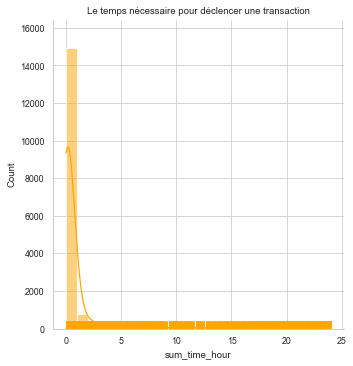

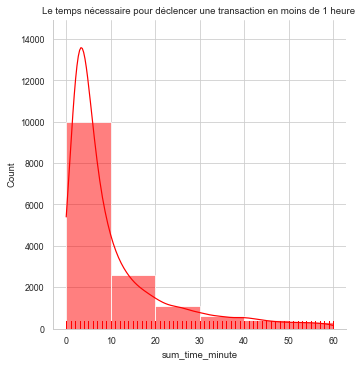

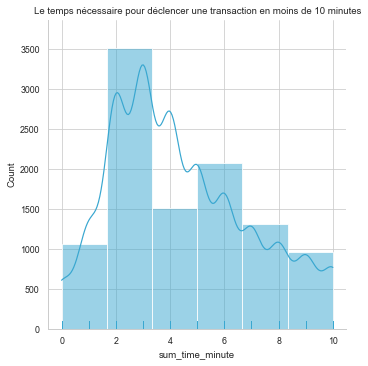

In [6]:
##### DATAVIZ SUR LES TEMPS ######

# Temps de Transactions moins d'une heure
sum_tran_1h = time_sum_tran.loc[round(time_sum_tran['sum_time_minute']) <= 60]

# Temps de transactions moins de 10 minutes
sum_trans_10min = sum_tran_1h.loc[round(sum_tran_1h['sum_time_minute']) <= 10]

sns.displot(time_sum_tran['sum_time_hour'], bins=24, kde=True, rug=True, color='orange')
plt.title('Le temps nécessaire pour déclencer une transaction')

sns.displot(sum_tran_1h['sum_time_minute'], bins=6, kde=True, rug=True, color='red')
plt.title('Le temps nécessaire pour déclencer une transaction en moins de 1 heure ')
          
sns.displot(sum_trans_10min['sum_time_minute'], bins=6, kde=True, rug=True)
plt.title('Le temps nécessaire pour déclencer une transaction en moins de 10 minutes');

In [5]:
### TABLEAU TIME SUM PAR VISITEURS ###

# Calculer le sum des evenements par transaction
v = calcul_time.groupby('visitorid', group_keys=False)
time_sum_visitor = pd.DataFrame(v['date_y'].apply(lambda x: (x.iat[-1] - x.iat[0])/ np.timedelta64(1, 's')))
time_sum_visitor = time_sum_visitor.rename(columns={"date_y": "sum_time_second"})
time_sum_visitor

# Convertir second en minute et en heure
time_sum_visitor['sum_time_minute'] = round(time_sum_visitor['sum_time_second']/60)
time_sum_visitor['sum_time_hour'] = round(time_sum_visitor['sum_time_second']/3600,2)
time_sum_visitor

,sum_time_second,sum_time_minute,sum_time_hour
visitorid,,,
172,2388.688,40.0,0.66
186,400.517,7.0,0.11
264,1532.878,26.0,0.43
419,7525.939,125.0,2.09
539,216.985,4.0,0.06
...,...,...,...
1406787,168.285,3.0,0.05
1406981,261.665,4.0,0.07
1407070,608.335,10.0,0.17


In [6]:
##### TABLEAU STATS PAR VISITEURS ####
# Nombre de visites
stats = df.groupby('visitorid').agg({'visitorid':'count'})
stats = stats.rename(columns={"visitorid": "nb_visites"})

# Nombre de views par visitorid
view = df.loc[df['event'] == 'view'].groupby('visitorid').agg({'visitorid':'count'})
view = view.rename(columns={"visitorid": "nb_views"})

# Nombre de addtocarts par visitorid
addtocart = df.loc[df['event'] == 'addtocart'].groupby('visitorid').agg({'visitorid':'count'})
addtocart = addtocart.rename(columns={"visitorid": "nb_addtocarts"})

#### STATS PAR VISITEUR #####
# Nombre de transactions par visitorid
transaction = df.loc[df['event']=='transaction'].groupby(by=['visitorid','transactionid'], as_index=False).agg({'itemid': 'count'})
all_transaction=transaction.groupby(by='visitorid').agg({'transactionid': 'count'}).rename(columns={"transactionid": "nb_transactions"})

# Merge les dataframes
stats = pd.merge(stats, view, left_index=True, right_index=True, how='left')
stats = pd.merge(stats, addtocart, left_index=True, right_index=True, how='left')
stats = pd.merge(stats, all_transaction, left_index=True, right_index=True, how='left')

# Merge items
items = df.loc[df['transactionid'] > 0].groupby(by='visitorid').agg({'itemid': 'count'})
stats = pd.merge(stats, items, left_index=True, right_index=True, how='left')
stats = stats.rename(columns={"itemid": "nb_items_bought"})

# Merge avec temps moyen passé
stats = pd.merge(stats, time_sum_visitor, left_index=True, right_index=True, how='left')
stats = stats.fillna(0)
stats = stats.sort_values('nb_transactions', ascending=False)

# Supprimer le visiteur 1150086
stats = stats.drop(stats.head(1).index)
stats = stats.sort_values('sum_time_minute', ascending=False)

# Temps moyen transaction 
stats['mean_time_tran_sec'] = stats['sum_time_second'] / stats['nb_transactions']
stats = stats.fillna(0)
stats['mean_time_tran_minute'] = round(stats['mean_time_tran_sec']/60)
stats['mean_time_tran_hour'] = round(stats['mean_time_tran_sec']/3600,2)

stats

,nb_visites,nb_views,nb_addtocarts,nb_transactions,nb_items_bought,sum_time_second,sum_time_minute,sum_time_hour,mean_time_tran_sec,mean_time_tran_minute,mean_time_tran_hour
visitorid,,,,,,,,,,,
1165148,858,802.0,29.0,23.0,27.0,1.105799e+07,184300.0,3071.66,4.807822e+05,8013.0,133.55
899857,528,342.0,114.0,51.0,72.0,1.104369e+07,184062.0,3067.69,2.165430e+05,3609.0,60.15
895999,2474,2368.0,56.0,44.0,50.0,1.046182e+07,174364.0,2906.06,2.377685e+05,3963.0,66.05
198153,536,494.0,32.0,10.0,10.0,1.038605e+07,173101.0,2885.01,1.038605e+06,17310.0,288.50
475172,135,108.0,14.0,8.0,13.0,1.029387e+07,171565.0,2859.41,1.286734e+06,21446.0,357.43
...,...,...,...,...,...,...,...,...,...,...,...
1389317,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.00
1389318,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.00
1389319,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.00


In [7]:
#### TABLEAU ITEMS ####
# Nombre de visiteurs par itemsid
items = df.groupby('itemid').agg({'visitorid':'count'})
items = items.rename(columns={"visitorid": "nb_visites"})

# Nombre de views par itemid
items_view = df.loc[df['event'] == 'view'].groupby('itemid').agg({'itemid':'count'}) #df.loc[df['itemid'] == 9]
items_view = items_view.rename(columns={"itemid": "nb_views"})

# Nombre de addtocarts par itemid
items_addtocart = df.loc[df['event'] == 'addtocart'].groupby('itemid').agg({'itemid':'count'})
items_addtocart = items_addtocart.rename(columns={"itemid": "nb_addtocarts"})

# Nombre de transactions par itemid
items_transaction = df.loc[df['event'] == 'transaction'].groupby('itemid').agg({'itemid':'count'})
items_transaction = items_transaction.rename(columns={"itemid": "nb_transactions"})

# Merge dataframes
items = pd.merge(items, items_view, left_index=True, right_index=True, how='left')
items = pd.merge(items, items_addtocart, left_index=True, right_index=True, how='left')
items = pd.merge(items, items_transaction, left_index=True, right_index=True, how='left')

# Merge avec temps moyen passé
items = items.fillna(0)
items = items.sort_values('nb_transactions', ascending=False)
items

,nb_visites,nb_views,nb_addtocarts,nb_transactions
itemid,,,,
461686,2978,2539.0,306.0,133.0
119736,893,752.0,44.0,97.0
213834,402,293.0,17.0,92.0
312728,1155,947.0,162.0,46.0
7943,1489,1346.0,97.0,46.0
...,...,...,...,...
159357,1,1.0,0.0,0.0
159359,13,13.0,0.0,0.0
159362,2,2.0,0.0,0.0


In [8]:
### TABLEAU TOP 500 PRODUITS ####
# SELECT 500 PRODUITS PLUS ACHETES, PLUS MIS AU PANIER, PLUS VUS
n_produits = 500

# les n_produits produits plus achetés
top_produits_vendus = items.sort_values(by='nb_transactions', ascending=False).head(n_produits)
top_produits_vendus['cat_top_vendus'] = "1"
top_produits_vendus = top_produits_vendus.drop(columns=['nb_visites', 'nb_views', 'nb_addtocarts'])

# les n_produits produits plus mis au panier
top_produits_paniers = items.sort_values(by='nb_addtocarts', ascending=False).head(n_produits)
top_produits_paniers['cat_top_mis_panier'] = "1"
top_produits_paniers = top_produits_paniers.drop(columns=['nb_visites', 'nb_views', 'nb_transactions'])

# les n_produits produits plus vus
top_produits_vus = items.sort_values(by='nb_views', ascending=False).head(n_produits)
top_produits_vus['cat_top_vus'] = "1"
top_produits_vus = top_produits_vus.drop(columns=['nb_visites', 'nb_addtocarts', 'nb_transactions'])

# Merge les 3 dataframes OUTER
top_produits = pd.merge(top_produits_vendus, top_produits_paniers, left_index=True, right_index=True, how='outer')
top_produits = pd.merge(top_produits, top_produits_vus, left_index=True, right_index=True, how='outer')

top_produits = top_produits[['cat_top_vus', 'cat_top_mis_panier', 'cat_top_vendus']]
top_produits = top_produits.fillna(0)
top_produits

,cat_top_vus,cat_top_mis_panier,cat_top_vendus
itemid,,,
546,1,1,1
829,0,1,1
869,1,1,1
1684,0,0,1
2416,0,1,1
...,...,...,...
465511,1,1,0
465522,0,1,1
465751,0,0,1


In [9]:
# MERGER POUR AVOIR LE SUIVI DES TOP PRODUITS LES PLUS ACHETES

top_produits_merged = pd.merge(items, top_produits, left_index=True, right_index=True, how='left')
top_produits_merged = top_produits_merged.sort_values(by=['nb_transactions'], ascending=False)
top_produits_merged = top_produits_merged.fillna(0)
top_produits_merged

,nb_visites,nb_views,nb_addtocarts,nb_transactions,cat_top_vus,cat_top_mis_panier,cat_top_vendus
itemid,,,,,,,
461686,2978,2539.0,306.0,133.0,1,1,1
119736,893,752.0,44.0,97.0,1,1,1
213834,402,293.0,17.0,92.0,0,1,1
312728,1155,947.0,162.0,46.0,1,1,1
7943,1489,1346.0,97.0,46.0,1,1,1
...,...,...,...,...,...,...,...
442427,47,46.0,1.0,0.0,0,0,0
442428,2,2.0,0.0,0.0,0,0,0
442431,136,133.0,3.0,0.0,0,0,0


In [13]:
top_produits_merged_bis=top_produits_merged.astype(int)

In [14]:
top_produits_merged_bis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235061 entries, 461686 to 466867
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   nb_visites          235061 non-null  int32
 1   nb_views            235061 non-null  int32
 2   nb_addtocarts       235061 non-null  int32
 3   nb_transactions     235061 non-null  int32
 4   cat_top_vus         235061 non-null  int32
 5   cat_top_mis_panier  235061 non-null  int32
 6   cat_top_vendus      235061 non-null  int32
 7   cat_star            235061 non-null  int32
dtypes: int32(8)
memory usage: 9.0 MB


In [47]:
### les 4 courbes de Sadali 





C:\Users\ocean\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


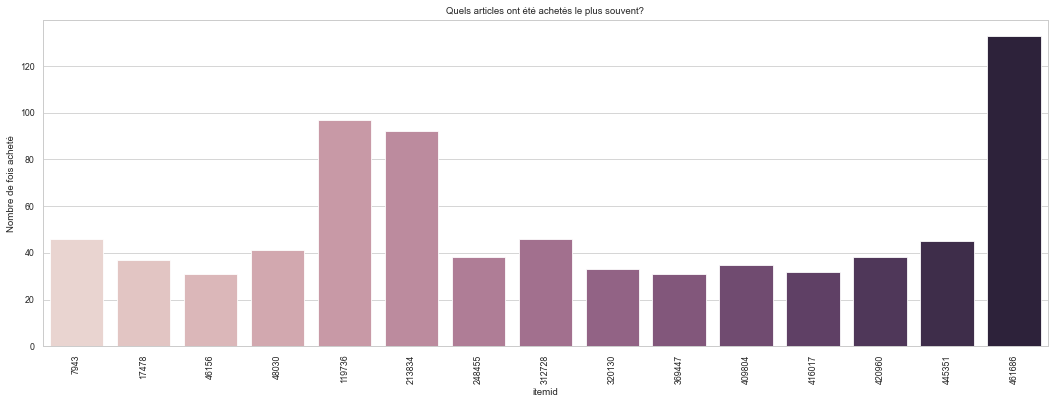

In [43]:
### Le top 15 des produits les plus achetés 

item_buy_test=items.head(15)
plt.figure(figsize=(18,6))
sns.barplot(item_buy_test.index, item_buy_test.nb_transactions,palette=sns.cubehelix_palette(15))
plt.ylabel("Nombre de fois acheté")
plt.title("Quels articles ont été achetés le plus souvent?");
plt.xticks(rotation=90);

In [ ]:
### Les produits stars ? ouverture 

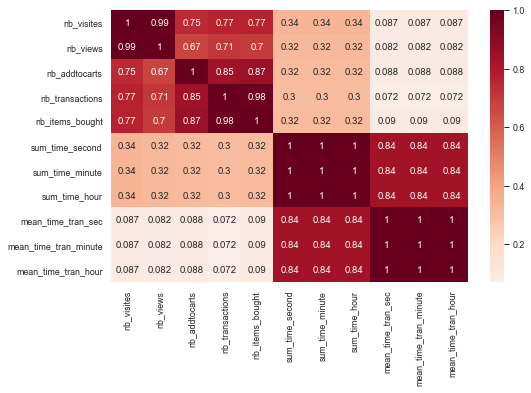

In [9]:
# MATRICE DE CORRELATION

plt.figure(figsize=(8,5))
sns.heatmap(stats.corr(), annot=True, cmap='RdBu_r', center=0);


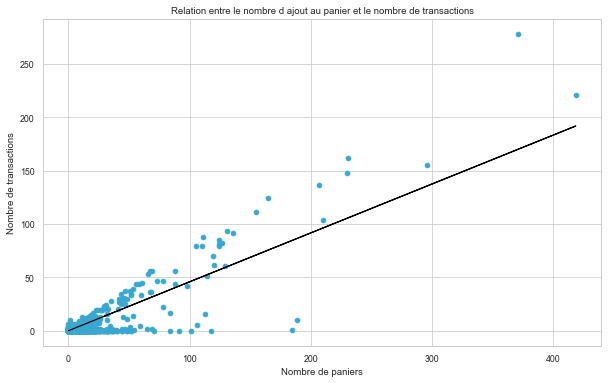

In [10]:
### DATAVIZ RELATION ADDTOCARTS & TRANSACTION ###

nb_addtocarts=stats[['nb_addtocarts']]

nb_transactions=stats[['nb_transactions']]

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, cross_validate

lr=LinearRegression()
lr.fit(nb_addtocarts, nb_transactions)
cross_validate(lr, nb_addtocarts, nb_transactions, return_train_score=True, cv=4)['test_score'].mean()

pred_t = lr.predict(nb_addtocarts)
residus = pred_t - nb_transactions

plt.figure(figsize=(10,6))
plt.scatter(x='nb_addtocarts', y='nb_transactions', data=stats)
plt.xlabel('Nombre de paniers')
plt.ylabel('Nombre de transactions')
plt.title('Relation entre le nombre d ajout au panier et le nombre de transactions')
plt.plot(nb_addtocarts, pred_t, color="black");

In [11]:
from scipy.stats import pearsonr

pd.DataFrame(pearsonr(stats['nb_addtocarts'], stats['nb_transactions']), index=['pearson_coeff', 'p-value'], columns=['Relation entre nb_addtocarts et nb_transactions'])

,Relation entre nb_addtocarts et nb_transactions
pearson_coeff,0.848033
p-value,0.000000


In [12]:
pd.DataFrame(pearsonr(stats['nb_views'], stats['nb_transactions']), index=['pearson_coef','p-value'], columns = ['Relation entre nb_views et nb_transactions'])


,Relation entre nb_views et nb_transactions
pearson_coef,0.708708
p-value,0.000000


In [24]:
### TABLEAU SUIVI VISIT & ITEM ###

visit_view = df.loc[df['event'] == 'view'].groupby(by=['visitorid','itemid'], as_index=False).agg({'event':'count'})
visit_view = visit_view.rename(columns={"event": "nb_view"})
visit_view.sort_values('nb_view', ascending=False)

# Nombre de paniers par visitorid, par item 
visit_add = df.loc[df['event'] == 'addtocart'].groupby(by=['visitorid','itemid'], as_index=False).agg({'event':'count'})
visit_add = visit_add.rename(columns={"event": "nb_addtocart"})
visit_add.sort_values('nb_addtocart', ascending=False)

# Nombre de transacs par visitorid, par item 
visit_transac = df.loc[df['event'] == 'transaction'].groupby(by=['visitorid','itemid'], as_index=False).agg({'event':'count'})
visit_transac = visit_transac.rename(columns={"event": "nb_transac"})
visit_transac.sort_values('nb_transac', ascending=False)

visit_item=pd.merge(visit_view, visit_add, how='outer')
visit_item=pd.merge(visit_item, visit_transac, how='outer')
visit_item.sort_values(['nb_transac','nb_addtocart', 'nb_view','visitorid', 'itemid'], ascending=[False, False, False, False, False])
visit_item.sort_values(by='nb_transac', ascending=False)

,visitorid,itemid,nb_view,nb_addtocart,nb_transac
231334,152963,119736,18.0,NaN,14.0
806384,530559,119736,19.0,9.0,9.0
1003673,660393,224549,9.0,6.0,5.0
1782155,1172087,312728,6.0,NaN,5.0
2070162,1365706,227311,4.0,5.0,5.0
...,...,...,...,...,...
2144647,1407512,54141,NaN,1.0,NaN
2144648,1407512,107832,NaN,1.0,NaN
2144649,1407512,241408,NaN,1.0,NaN
2144650,1407512,290723,NaN,1.0,NaN


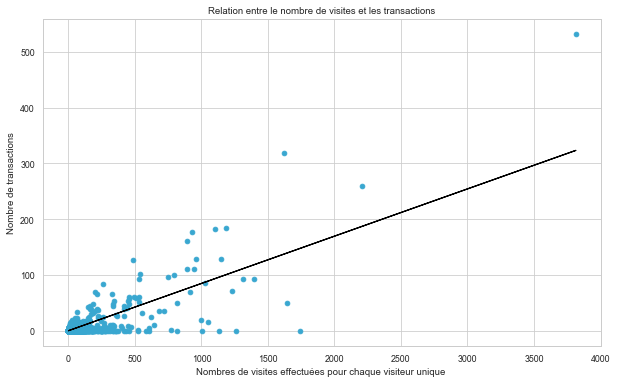

In [14]:
### DATAVIZ RELATION VISITE & TRANSACTION ###

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, cross_validate

# On va faire un groupement des visitors qui achètent le plus 
visitor_transaction=visit_item.groupby(by='visitorid').agg({'nb_transac':'count', 'visitorid':'count'}).rename(columns={'visitorid':'nb_de_visit'})

nb_transactions=visitor_transaction['nb_transac']
view_by_visitor=visitor_transaction[['nb_de_visit']]

slr=LinearRegression()
slr.fit(view_by_visitor, nb_transactions)
cross_validate(slr, view_by_visitor, nb_transactions, return_train_score=True, cv=4)['test_score'].mean()

pred_transac = slr.predict(view_by_visitor)
residus = pred_transac - nb_transactions

plt.figure(figsize=(10,6))
plt.scatter(x='nb_de_visit', y='nb_transac', data=visitor_transaction)
plt.xlabel('Nombres de visites effectuées pour chaque visiteur unique ')
plt.ylabel('Nombre de transactions')
plt.title('Relation entre le nombre de visites et les transactions');
plt.plot(view_by_visitor, pred_transac, color="black");


In [16]:
print("la p-value < 5%, le coefficient est proche de 1, il y a une corrélation entre les deux variables.")
print("Lorsque le nombre de view augmentent les transactions augmentent aussi.")

pd.DataFrame(pearsonr(visitor_transaction['nb_de_visit'],visitor_transaction['nb_transac']), index = ['pearson_coeff','p-value'], columns = ['resultat_test'])


la p-value < 5%, le coefficient est proche de 1, il y a une corrélation entre les deux variables.
Lorsque le nombre de view augmentent les transactions augmentent aussi.


,resultat_test
pearson_coeff,0.777609
p-value,0.000000


In [ ]:
# Après avoir effectuer des premières corrélations, nous allons tenter de choisir notre modèle 
# Nous partons sur un clustering 
# L'idée est de faire un nuage de points pour prendre la température
# D'abord la méthode de coude pour avoir le nombre de clusters 
# Essayons avec le dataset 

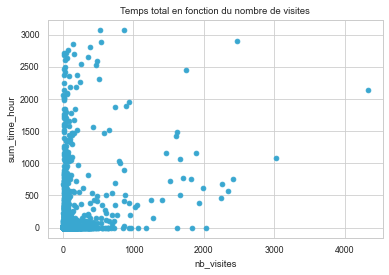

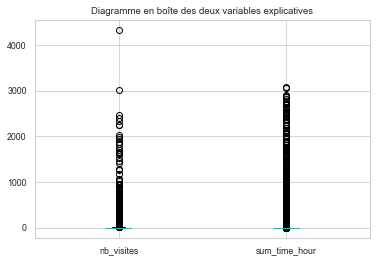

In [22]:
## création d'un nouveau df "stats_1" afin d'afficher un premier mapping
## Choix arbitraire au hasard ... 

stats_1 = stats[['nb_visites','sum_time_hour']]
stats_1.head()

#affichage du graphique Temps moyen en fonction du nombre de visites
plt.scatter(stats_1['nb_visites'],stats_1['sum_time_hour'])
plt.ylabel('sum_time_hour')
plt.xlabel('nb_visites')
plt.title('Temps total en fonction du nombre de visites')
plt.show()

#boites à moustaches des deux variables
liste = [stats_1['nb_visites'], stats_1['sum_time_hour']]
plt.figure()
plt.title('Diagramme en boîte des deux variables explicatives')
plt.boxplot(liste, labels = ['nb_visites', 'sum_time_hour'])
plt.show()

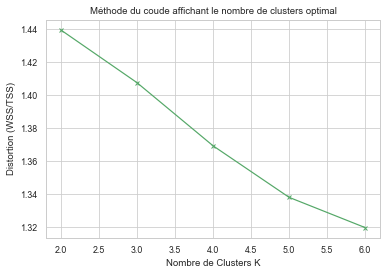

In [29]:
# Test de la méthode de coude 
# Coude pas forcément lisible donc on va faire un dendrogramme ...

from scipy.spatial.distance import cdist

range_n_clusters = [2, 3, 4, 5, 6]  

distortions = []

for n_clusters in range_n_clusters:
    
    cluster = KMeans(n_clusters = n_clusters)
    
    cluster.fit(stats_1)
    
    distortions.append(sum(np.min(cdist(stats_1, cluster.cluster_centers_, 'euclidean'), axis=1)) / np.size(stats_1, axis = 0))
    
plt.plot(range_n_clusters, distortions, 'gx-')
plt.xlabel('Nombre de Clusters K')
plt.ylabel('Distortion (WSS/TSS)')
plt.title('Méthode du coude affichant le nombre de clusters optimal')
plt.show()

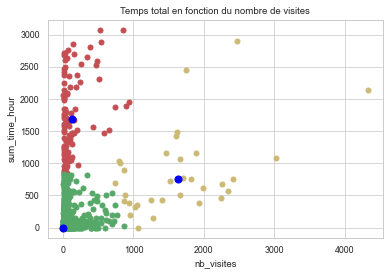

array([[1.90000945e+00, 7.49884435e-02],
       [1.27853211e+02, 1.68773624e+03],
       [1.62897297e+03, 7.53507027e+02]])

In [32]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(stats_1)

# Centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

#Visualisation des clusters et des centroïdes 
# Liste des couleurs
colors = ["g.","r.","y."]

# Graphique du nuage de points attribués au cluster correspondant
# Graphique réalisé sur une base de 10 000 lignes car limite du googlecolab et notebook 
# ça nous donne une bonne approche

for i in range(10000):
    plt.plot(stats_1.iloc[i,0], stats_1.iloc[i,1], colors[labels[i]], markersize = 10)
# Graphique des centroïdes
plt.scatter(centroids[:, 0],centroids[:, 1], marker = "o", color = "blue",s=50, linewidths = 1, zorder = 10)
plt.ylabel('sum_time_hour')
plt.xlabel('nb_visites')
plt.title('Temps total en fonction du nombre de visites')
plt.show()

centroids

In [ ]:
### Classification mixte sur les 3 datasets donc time, stat et items

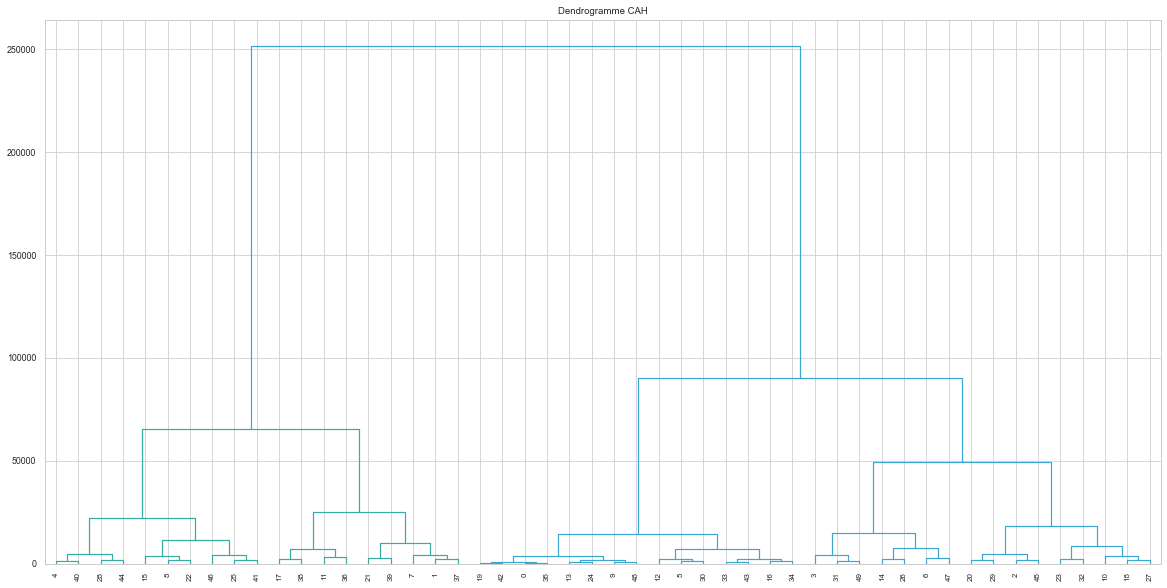

C:\Users\ocean\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,sum_time_second,sum_time_minute,sum_time_hour,kmean1_label,agglo_label,kmean2_label
transactionid_x,,,,,,
0.0,530.511,9.0,0.15,0,2.0,2
1.0,559.408,9.0,0.16,0,2.0,2
2.0,189.096,3.0,0.05,19,2.0,2
3.0,0.000,0.0,0.00,19,2.0,2
4.0,299.570,5.0,0.08,42,2.0,2
...,...,...,...,...,...,...
17667.0,430.500,7.0,0.12,42,2.0,2
17668.0,159.337,3.0,0.04,19,2.0,2
17669.0,156.841,3.0,0.04,19,2.0,2


In [46]:
#### CLUSTERING SUR LE TABLEAU CI-DESSUS : TIME SUM TRANSACTIONS ####

k1 = KMeans(n_clusters=50).fit(time_sum_tran)
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

# Agglo par 3
ac = AgglomerativeClustering(n_clusters = 3).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

time_sum_tran['kmean1_label'] = k1.labels_

# Ajouter la colonne agglo_label
for i in list(cd.index):
    time_sum_tran.loc[time_sum_tran['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# Get new centroids = mean of 3 labels from Agglo
new_centroids = time_sum_tran.groupby('agglo_label').mean()
new_time_sum_tran = time_sum_tran.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=3, init=new_centroids)
k2.fit(new_time_sum_tran)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

# Ajouter la colonne kmean2_label
time_sum_tran['kmean2_label'] = k2.labels_
time_sum_tran

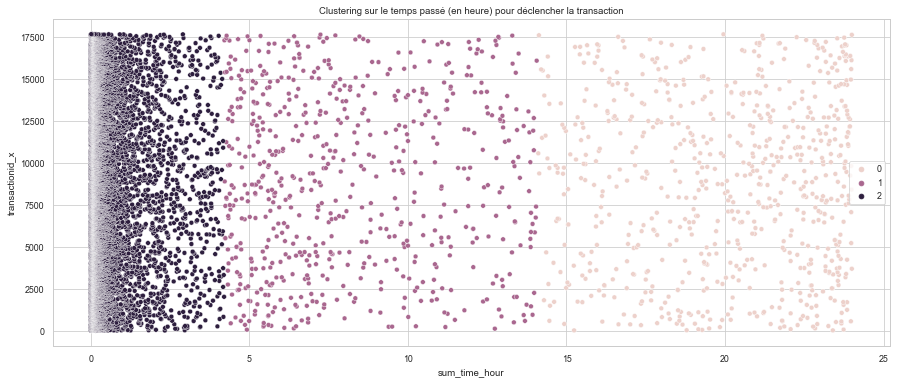

In [52]:
### NUAGE DE POINTS sum_time_hour 

import seaborn as sns
plt.figure(figsize=(15,6))
sns.scatterplot(data=time_sum_tran, x="sum_time_hour", y=time_sum_tran.index, hue="kmean2_label")
plt.title('Clustering sur le temps passé (en heure) pour déclencher la transaction')
plt.legend(loc='center right');

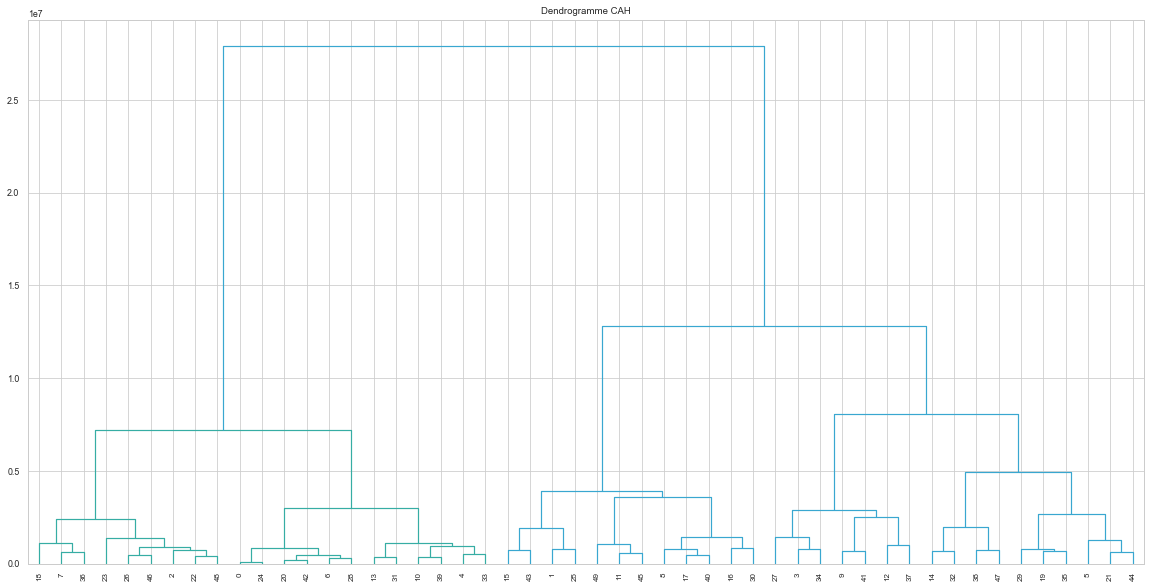

C:\Users\ocean\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,nb_visites,nb_views,nb_addtocarts,nb_transactions,nb_items_bought,sum_time_second,sum_time_minute,sum_time_hour,mean_time_tran_sec,mean_time_tran_minute,mean_time_tran_hour,kmean1_label,agglo_label,kmean2_label
visitorid,,,,,,,,,,,,,,
1165148,858,802.0,29.0,23.0,27.0,1.105799e+07,184300.0,3071.66,4.807822e+05,8013.0,133.55,44,0.0,0
899857,528,342.0,114.0,51.0,72.0,1.104369e+07,184062.0,3067.69,2.165430e+05,3609.0,60.15,44,0.0,0
895999,2474,2368.0,56.0,44.0,50.0,1.046182e+07,174364.0,2906.06,2.377685e+05,3963.0,66.05,21,0.0,0
198153,536,494.0,32.0,10.0,10.0,1.038605e+07,173101.0,2885.01,1.038605e+06,17310.0,288.50,5,0.0,0
475172,135,108.0,14.0,8.0,13.0,1.029387e+07,171565.0,2859.41,1.286734e+06,21446.0,357.43,5,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389317,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.00,0,1.0,1
1389318,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.00,0,1.0,1
1389319,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.00,0,1.0,1


In [53]:
#### CLUSTERING SUR LE TABLEAU CI-DESSUS : STATS ####

k1 = KMeans(n_clusters=50).fit(stats)
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

# AGGLOMERATIVECLUSTERING PAR 3
ac = AgglomerativeClustering(n_clusters = 3).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

stats['kmean1_label'] = k1.labels_

# DATA CLUSTERING    
for i in list(cd.index):
    stats.loc[stats['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# GET NEW CENTROIDS = MEAN OF AGGLO 3 LABELS
new_centroids = stats.groupby('agglo_label').mean()
new_stats = stats.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=3, init=new_centroids)
k2.fit(new_stats)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

stats['kmean2_label'] = k2.labels_
stats

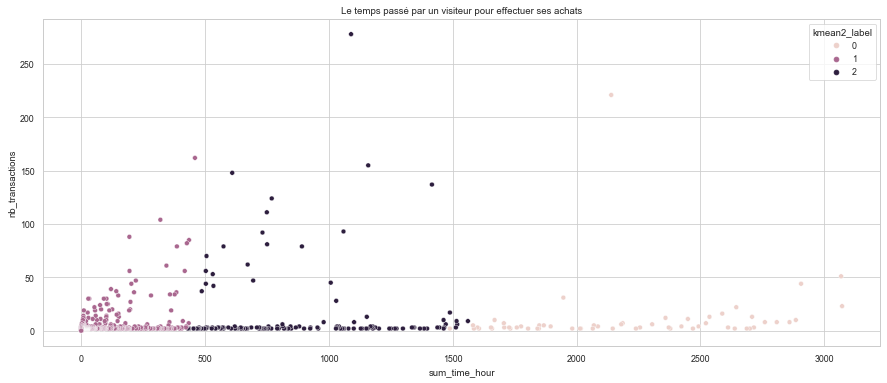

In [55]:
### VISUALISATION RESULTATS CLUSTERING STATS ###

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="sum_time_hour", y="nb_transactions",hue='kmean2_label')
plt.title('Le temps passé par un visiteur pour effectuer ses achats');

In [21]:
test=top_produits_merged.loc[(top_produits_merged['nb_transactions']>0)]
test

,nb_visites,nb_views,nb_addtocarts,nb_transactions,cat_top_vus,cat_top_mis_panier,cat_top_vendus,cat_star
itemid,,,,,,,,
461686,2978,2539.0,306.0,133.0,1,1,1,3
119736,893,752.0,44.0,97.0,1,1,1,3
213834,402,293.0,17.0,92.0,0,1,1,2
312728,1155,947.0,162.0,46.0,1,1,1,3
7943,1489,1346.0,97.0,46.0,1,1,1,3
...,...,...,...,...,...,...,...,...
21728,32,29.0,2.0,1.0,0,0,0,0
371067,8,6.0,1.0,1.0,0,0,0,0
21746,228,225.0,2.0,1.0,0,0,0,0


In [22]:

# Définition de la liste de n_clusters
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# Initialisation de la liste des coefficients de la silhouette score
s_scores = []

# Calcul du coefficient de silhouette pour les différentes valeurs de n_clusters
for i in range_n_clusters :
    
    # Initialisation du classificateur CAH pour n_clusters
    cluster = AgglomerativeClustering(n_clusters = i)

    # Apprentissage des données 
    cluster.fit(test)

    # Calcul des labels du data set
    labels = cluster.labels_
    
    # Caclul du coefficient de silhouette
    s_score = silhouette_score(test, labels, metric='sqeuclidean')
    s_scores.append(s_score)

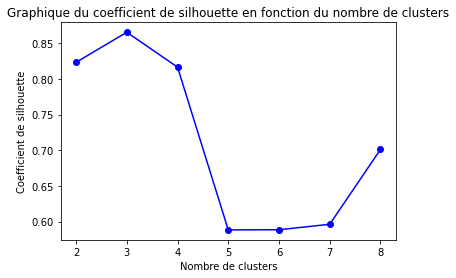

In [23]:
# Graphique du coefficient de silhouette en fonction du nombre de clusters
plt.plot(range_n_clusters, s_scores, 'bo-')
plt.title('Graphique du coefficient de silhouette en fonction du nombre de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.show()

In [ ]:
### ANNEXE ###